Se cargó la Base de Datos Hospitales_Normalizados

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


In [168]:
data = pd.read_csv('Hospitales_Normalizados.csv')
data.head()
data.drop(columns=['Unnamed: 0'])

,EDAD,DIABETES,HOSPITALIZACIÓN ULTIMO MES,PSA,NUMERO DE MUESTRAS TOMADAS,ENF. CRONICA PULMONAR OBSTRUCTIVA,FIEBRE,ITU,HOSPITALIZACION
0,53.0,0,0,4.0,12.0,0,1,0,1
1,56.0,0,0,7.7,12.0,0,1,0,1
2,57.0,0,0,29.0,24.0,0,1,0,1
3,56.0,0,0,7.0,12.0,0,1,0,1
4,55.0,0,0,29.0,24.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
552,57.0,0,0,4.8,12.0,0,0,0,0
553,75.0,0,0,75.0,12.0,0,0,0,0
554,78.0,0,0,9.3,12.0,0,0,0,0
555,67.0,0,0,6.0,12.0,0,0,0,0


Se separó el dataset en X, Y (variable objetivo). Primero será para el todas de las columnas

In [169]:
X = data.iloc[:, [1,2,3,4,5,6,7,8]].values
Y = data.iloc[:, 9].values
print(X.shape)
print(Y.shape)

(557, 8)
(557,)


 Se separó el dataset en X_train, X_test, Y_train y Y_test

In [170]:
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.2, random_state=0)

Estandarizamos 

In [171]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(X_Train)
X_Test = sc_X.transform(X_Test)

Entrenamos. Para ello, utilizamos la clase `SVC` de la librería Scikit-Learn

In [172]:
from sklearn.svm import SVC

classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_Train, Y_Train)

SVC(kernel='linear', random_state=0)

Predecimos

In [173]:
y_train_pred = classifier.predict(X_Train)

y_test_pred = classifier.predict(X_Test)

Obtenemos exactitud

In [174]:
accuracy = classifier.score(X_Test, Y_Test)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9821428571428571


Graficamos la matriz de confusión

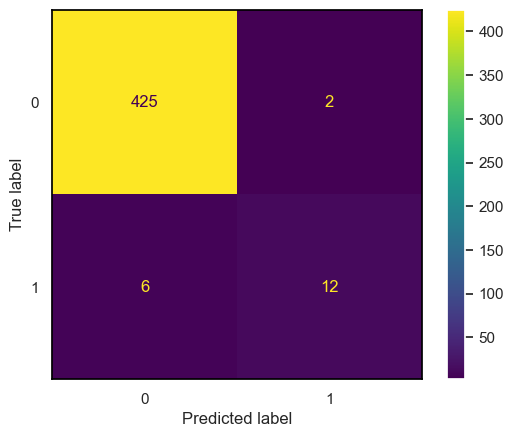

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.99      1.00      0.99       427
           1       0.86      0.67      0.75        18

    accuracy                           0.98       445
   macro avg       0.92      0.83      0.87       445
weighted avg       0.98      0.98      0.98       445



In [175]:
#Para crear la matriz de confusión
matrix = confusion_matrix(Y_Train, y_train_pred)
matrix_2 = confusion_matrix(Y_Test, y_test_pred)

#Para visualizar
cm_display = ConfusionMatrixDisplay(matrix)
cm_display_2 = ConfusionMatrixDisplay(matrix_2)

#MATRIZ DE ENTRENAMIENTO
cm_display.plot()
spines = plt.gca().spines
# Establecer el color de línea de los ejes a negro
for spine in spines.values():
    spine.set_color('black')
plt.grid(False)
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Train, y_train_pred)}''')

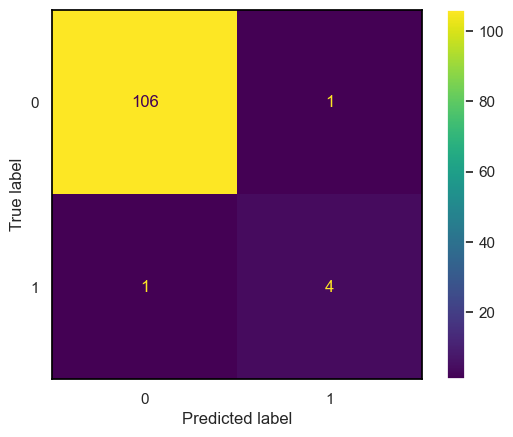

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.80      0.80      0.80         5

    accuracy                           0.98       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.98      0.98      0.98       112



In [176]:
#MATRIZ DE TESTEO
cm_display_2.plot()
spines = plt.gca().spines
# Establecer el color de línea de los ejes a negro
for spine in spines.values():
    spine.set_color('black')
plt.grid(False)
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(Y_Test, y_test_pred)}''')

Para poder visualizar en un gráfico de `SVM` elegiremos pares de categorìas, entrenaremos por pares de categorías, debido a las limitaciones de memoria

NUMERO DE MUESTRAS TOMADAS E ITU

Entrenamos nuestro modelo

In [177]:
#Elegimos columnas
X1 = data.iloc[:, [5,8]].values
Y1 = data.iloc[:, 9].values

#Separamos dataset
X1_Train, X1_Test, Y1_Train, Y1_Test = train_test_split(X1, Y1, test_size = 0.2, random_state=0)

#Estandarizamos
sc_X1 = StandardScaler()
X1_Train = sc_X1.fit_transform(X1_Train)
X1_Test = sc_X1.transform(X1_Test)

#Entrenamos
classifier1 = SVC(kernel='linear', random_state=0)
classifier1.fit(X1_Train, Y1_Train)

#Predecimos
y1_pred = classifier1.predict(X1_Test)

#Calculamos exactitud
accuracy = classifier1.score(X1_Test, Y1_Test)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9642857142857143


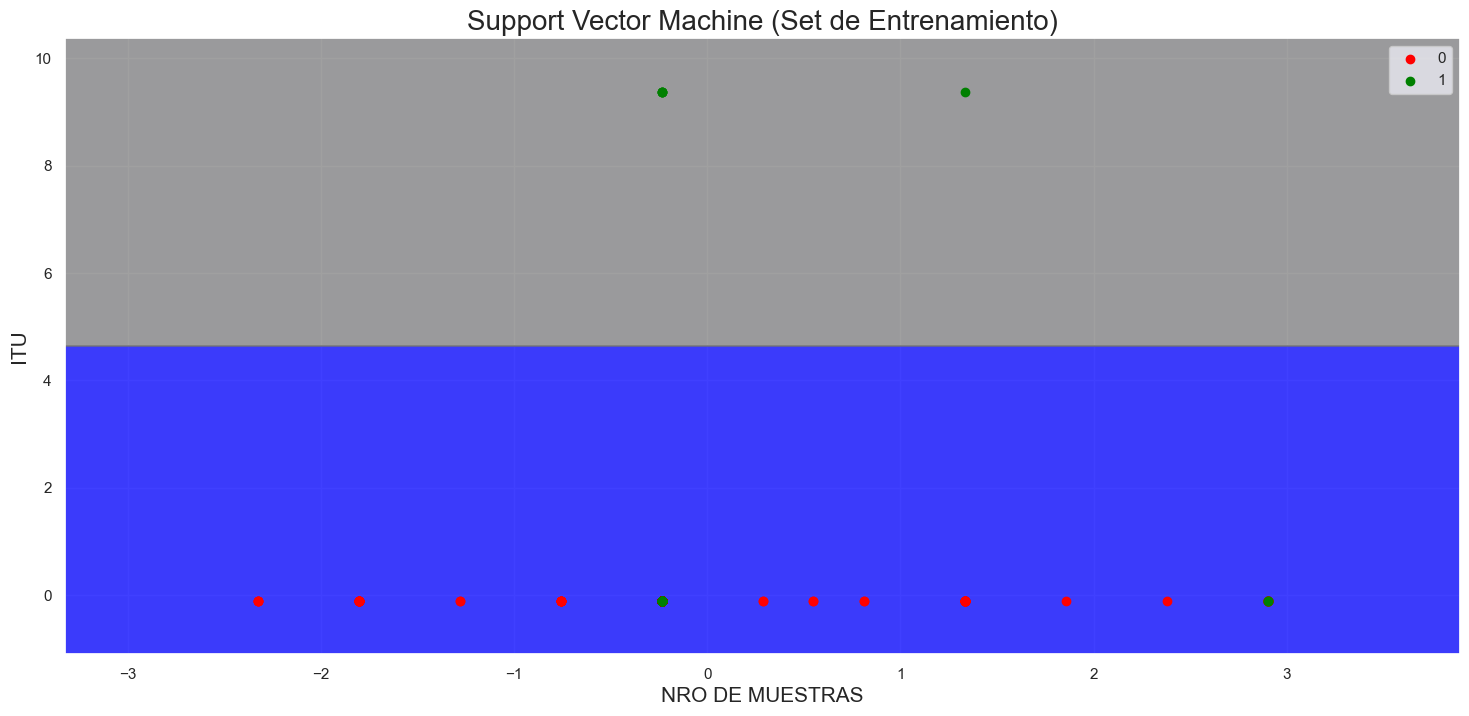

In [180]:
# Set de entrenamiento

from matplotlib.colors import ListedColormap

X1_Set, Y1_Set = X1_Train, Y1_Train
X1, X2 = np.meshgrid(np.arange(start = X1_Set[:, 0].min() - 1, stop = X1_Set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X1_Set[:, 1].min() - 1, stop = X1_Set[:, 1].max() + 1, step = 0.01))

plt.figure(figsize=(18,8))
plt.contourf(X1, X2, classifier1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('blue', 'gray')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(Y1_Set)):
    plt.scatter(X1_Set[Y1_Set == j, 0], X1_Set[Y1_Set == j, 1],
                c = [ListedColormap(('red', 'green'))(i)], label = j)
plt.title('Support Vector Machine (Set de Entrenamiento)', fontsize=20)
plt.xlabel('NRO DE MUESTRAS', fontsize=15)
plt.ylabel('ITU', fontsize=15)
plt.legend()
plt.show()



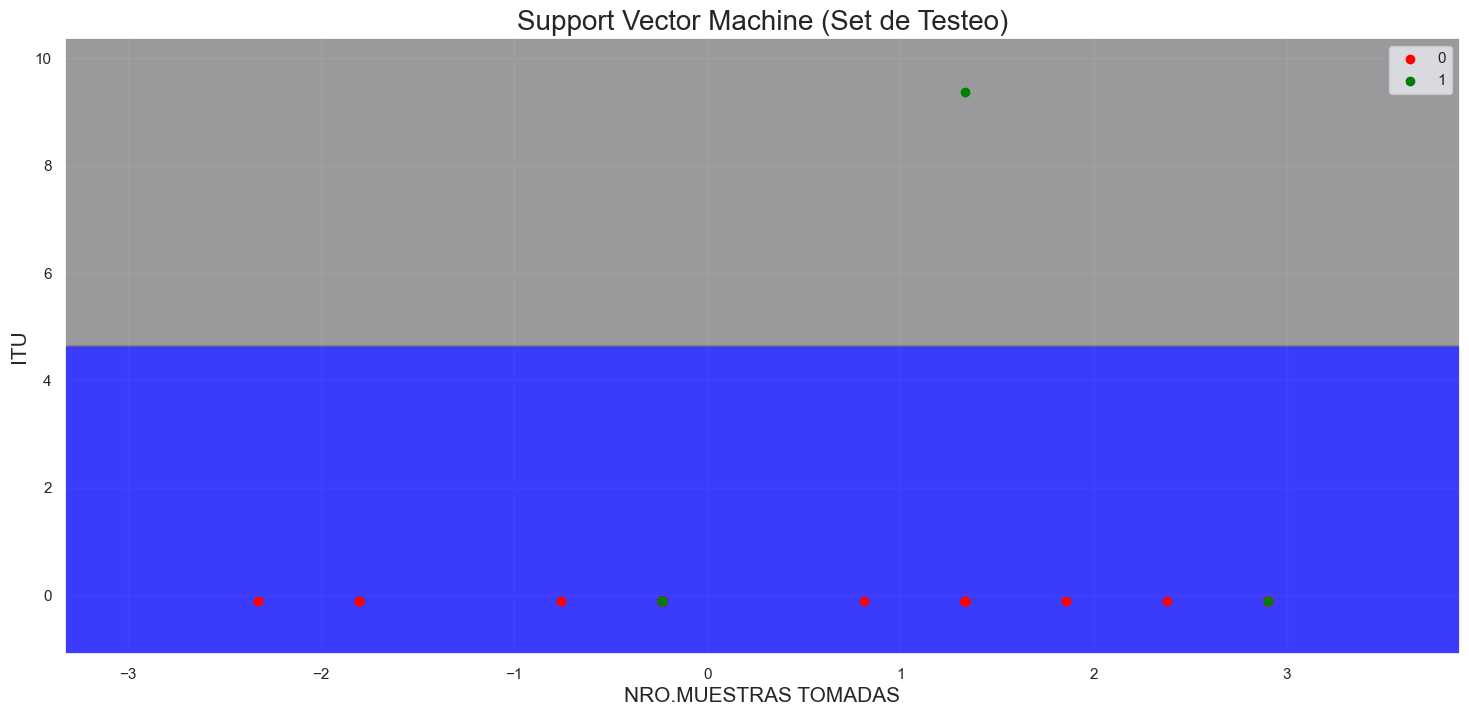

In [179]:
X1_Set, Y1_Set = X1_Test, Y1_Test
X1, X2 = np.meshgrid(np.arange(start = X1_Set[:, 0].min() - 1, stop = X1_Set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X1_Set[:, 1].min() - 1, stop = X1_Set[:, 1].max() + 1, step = 0.01))

plt.figure(figsize=(18,8))
plt.contourf(X1, X2, classifier1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(['blue', 'gray']))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(Y1_Set)):
    plt.scatter(X1_Set[Y1_Set == j, 0], X1_Set[Y1_Set == j, 1],
                c = [ListedColormap(('red', 'green'))(i)], label = j)
plt.title('Support Vector Machine (Set de Testeo)', fontsize=20)
plt.xlabel('NRO.MUESTRAS TOMADAS', fontsize=15)
plt.ylabel('ITU', fontsize=15)
plt.legend()
plt.show()